##Loading Data
load google drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


check total number of bat and human images in the directories

In [3]:
import os

# Directories with training human and bat pictures
train_bat_dir = os.path.join('./drive/My Drive/training_dataset/bat-or-human/bats')
train_human_dir = os.path.join('./drive/My Drive/training_dataset/bat-or-human/humans')

validation_bat_dir = os.path.join('./drive/My Drive/validation_dataset/bat-or-human/bats')
validation_human_dir = os.path.join('./drive/My Drive/validation_dataset/bat-or-human/humans')

print('total training bat images:', len(os.listdir(train_bat_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))
print()
print('total validation bat images:', len(os.listdir(validation_bat_dir)))
print('total validation human images:', len(os.listdir(validation_human_dir)))

total training bat images: 377
total training human images: 424

total validation bat images: 38
total validation human images: 214


## Building Model

import tensorflow.

ensure using version 2.x, or some components will be imcompatible.

In [0]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.1.0

import tensorflow as tf
tf.__version__

'2.1.0'

CNN graph.

In [0]:
model = tf.keras.models.Sequential([
    # convolution layers
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron, 0-1.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model summary.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

loss, optimizer, metrics specification.

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

### Data Preprocessing

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128
train_generator = train_datagen.flow_from_directory(
        './drive/My Drive/training_dataset/bat-or-human/',
        target_size=(300, 300),
        batch_size=64,
        class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
        './drive/My Drive/validation_dataset/bat-or-human/',
        target_size=(300, 300),
        batch_size=32,
        class_mode='binary')

print("training set:", train_generator.class_indices)
print("validation set:", validation_generator.class_indices)

Found 800 images belonging to 2 classes.
Found 251 images belonging to 2 classes.
training set: {'bats': 0, 'humans': 1}
validation set: {'bats': 0, 'humans': 1}


### Training And Validation
callbacks, allow model to stop once acc is over 95%

In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('acc') > 0.95):
            print("Reached 95.0% accuracy, training is stopped")
            self.model.stop_training = True

train for 15 epochs, but if acc of 95.0% is reached, training will be stoped.

In [0]:
history = model.fit(
      train_generator,
      steps_per_epoch=12,  
      epochs=15,
      validation_data=validation_generator,
      validation_steps=8,
      verbose=1,
      callbacks=[myCallback()])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 8 steps
Epoch 1/15
12/12 [==============================] - 275s 23s/step - loss: 0.9789 - acc: 0.6141 - val_loss: 0.7092 - val_acc: 0.8167
Epoch 2/15
12/12 [==============================] - 5s 413ms/step - loss: 0.4867 - acc: 0.7418 - val_loss: 0.5798 - val_acc: 0.8406
Epoch 3/15
12/12 [==============================] - 5s 404ms/step - loss: 0.4801 - acc: 0.7568 - val_loss: 0.4868 - val_acc: 0.8486
Epoch 4/15
12/12 [==============================] - 5s 421ms/step - loss: 0.4473 - acc: 0.7704 - val_loss: 0.3336 - val_acc: 0.8685
Epoch 5/15
12/12 [==============================] - 5s 418ms/step - loss: 0.4426 - acc: 0.7731 - val_loss: 0.2776 - val_acc: 0.8645
Epoch 6/15
12/12 [==============================] - 5s 414ms/step - loss: 0.4281 - acc: 0.7867 - val_loss: 0.4533 - val_acc: 0.8685
Epoch 7/15
12/12 [==============================] - 5s 433ms/step - loss: 0.3517 - acc: 0.8247 - val_loss: 0.2958 - v

###Realtime Prediction

upload and predict.

Saving bat.jpeg to bat (1).jpeg
Saving trump.jpeg to trump (1).jpeg
[0.]
bat.jpeg is a bat
prediction 1 costs 0.10814714431762695 seconds
[1.]
trump.jpeg is a human
prediction 2 costs 0.028115510940551758 seconds


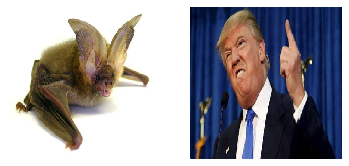

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import time
import matplotlib.pyplot as plt

uploaded = files.upload()
count = 1

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  
  # show the image predicted
  sp = plt.subplot(1, 2, count)
  sp.axis('Off')
  plt.imshow(img)

  timer_1 = time.time()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a bat")
  
  timer_2 = time.time()

  print("prediction", count, "costs", timer_2-timer_1, "seconds")
  count += 1

## Clean Up

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)